In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import joblib

# Set up a consistent visual style
sns.set(style="whitegrid")

In [2]:
# Step 2: Load Dataset
# Loading the dataset into a Pandas DataFrame
data_path = "./dataset.csv"  # Update this path with the actual file location
df = pd.read_csv(data_path)

print(f"Dataset Shape: {df.shape}")
print(f"Columns: {df.columns}")

Dataset Shape: (300153, 12)
Columns: Index(['Unnamed: 0', 'airline', 'flight', 'source_city', 'departure_time',
       'stops', 'arrival_time', 'destination_city', 'class', 'duration',
       'days_left', 'price'],
      dtype='object')


## Problem Selection

The problem of predicting flight prices is highly relevant to industries like travel and hospitality. Understanding pricing behavior helps airlines optimize revenue and assists passengers in planning cost-effective travel. It ties closely to machine learning topics like regression, feature engineering, and ensemble modeling.



Dataset Shape: (300153, 12)
Columns: Index(['Unnamed: 0', 'airline', 'flight', 'source_city', 'departure_time',
       'stops', 'arrival_time', 'destination_city', 'class', 'duration',
       'days_left', 'price'],
      dtype='object')
Data Types:
Unnamed: 0            int64
airline              object
flight               object
source_city          object
departure_time       object
stops                object
arrival_time         object
destination_city     object
class                object
duration            float64
days_left             int64
price                 int64
dtype: object
Missing Values:
Unnamed: 0          0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64


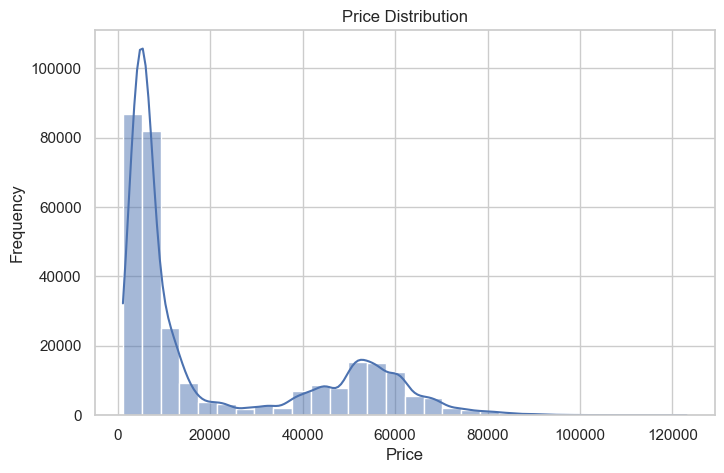

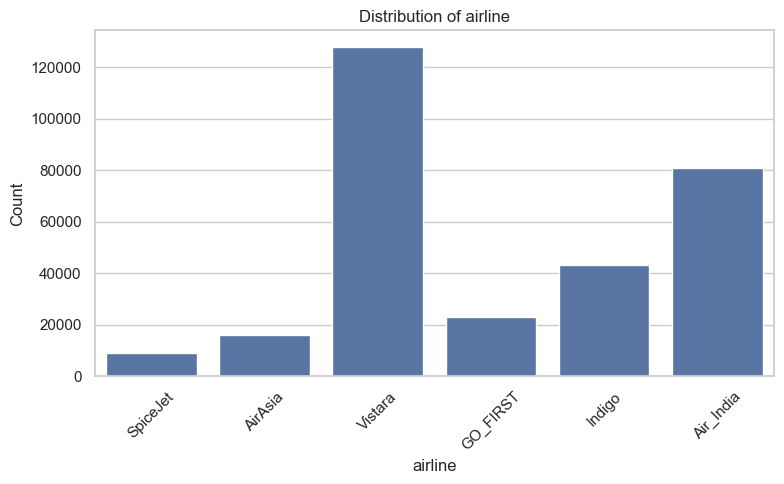

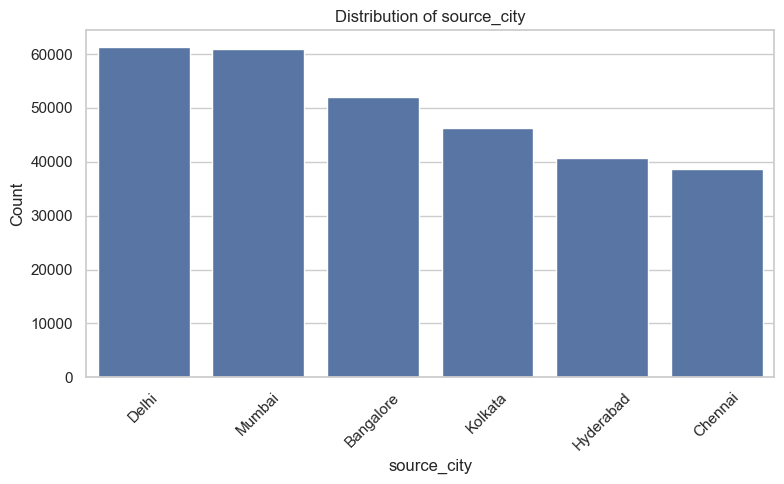

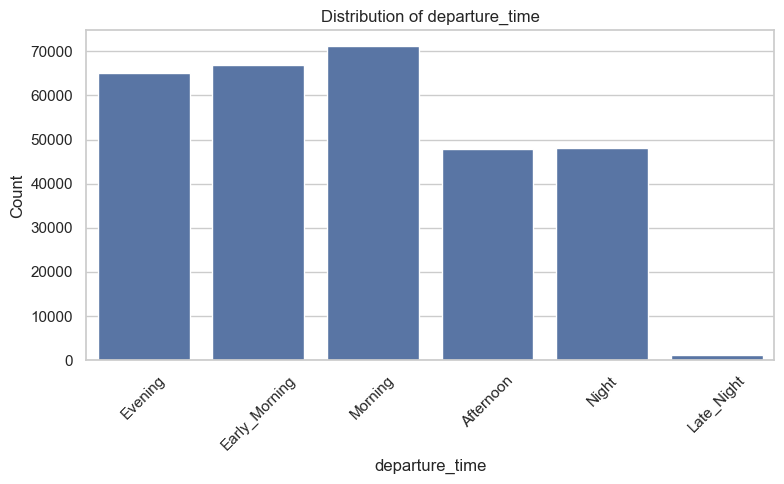

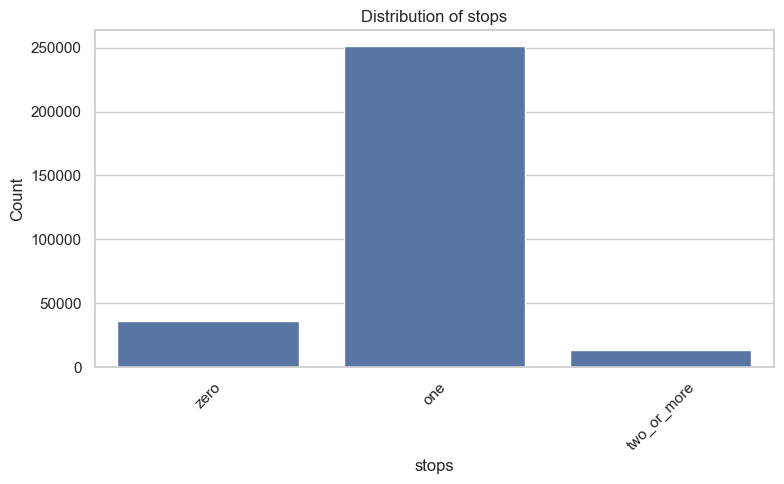

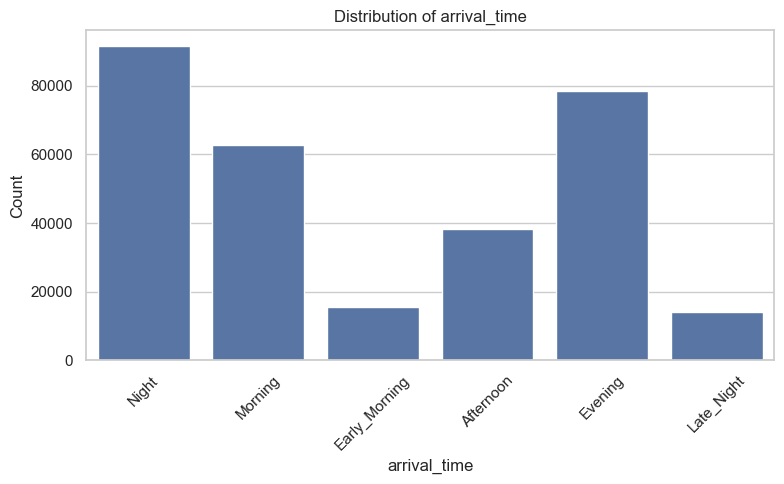

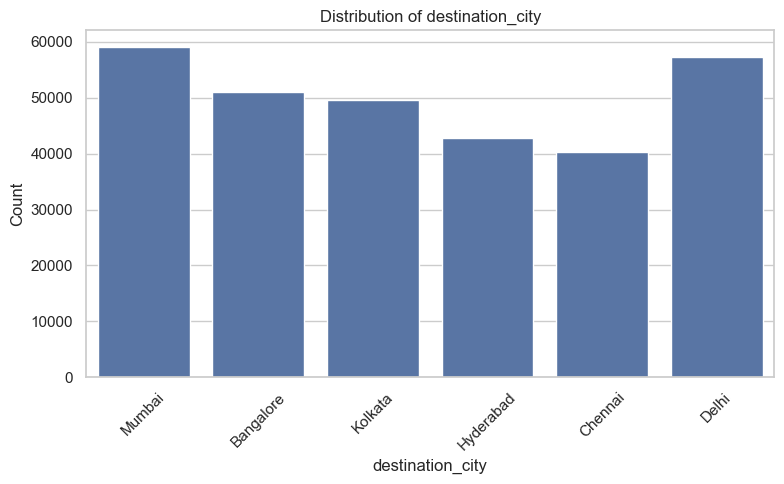

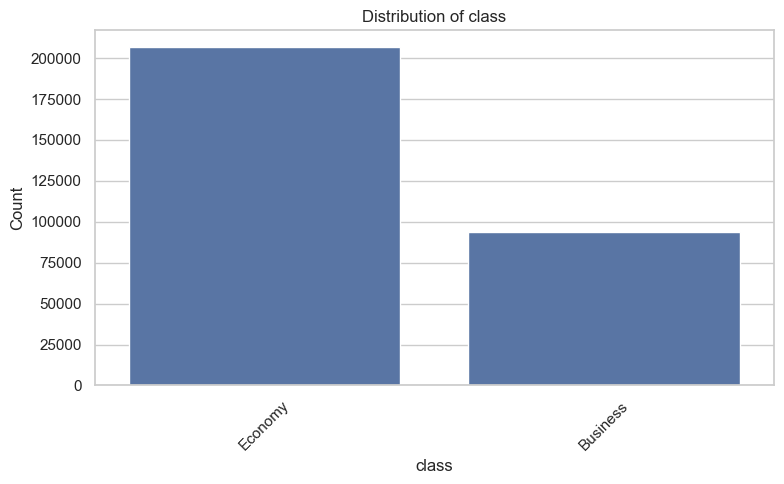

In [3]:
# Step 3: Data Exploration
# Analyze dataset shape, columns, and data types
print(f"Dataset Shape: {df.shape}")
print(f"Columns: {df.columns}")
print(f"Data Types:\n{df.dtypes}")

# Check for missing values
print(f"Missing Values:\n{df.isnull().sum()}")

# Summary statistics of the dataset
df.describe()

# Visualize price distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["price"], kde=True, bins=30)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

# Categorical feature analysis
categorical_columns = [
    "airline",
    "source_city",
    "departure_time",
    "stops",
    "arrival_time",
    "destination_city",
    "class",
]
for col in categorical_columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=df[col])
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"./visualization/{col}_distribution.png", dpi=100)
    plt.show()

# Data Visualization

## Plot 1: Distribution of Flight Prices

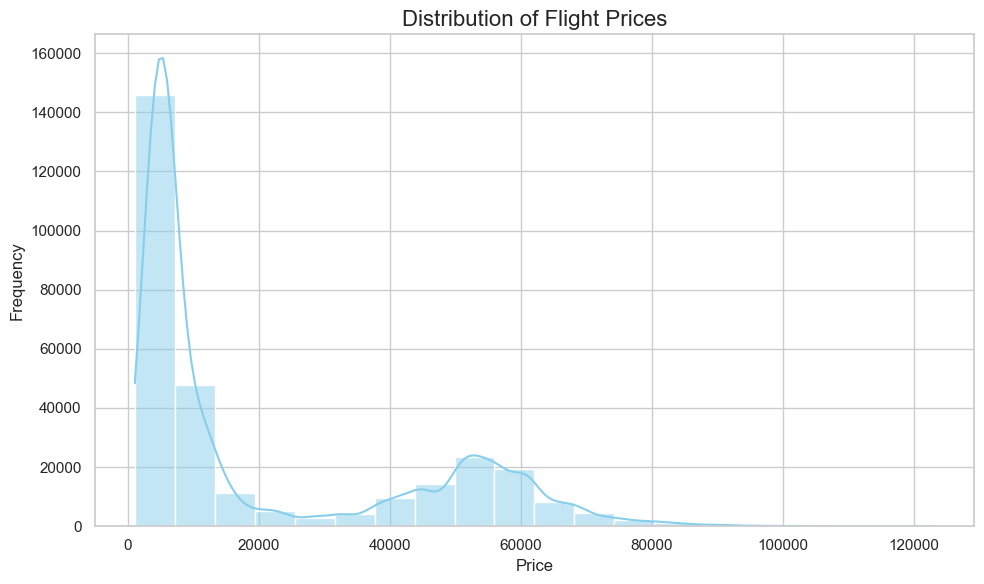

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(df["price"], kde=True, color="skyblue", bins=20)
plt.title("Distribution of Flight Prices", fontsize=16)
plt.xlabel("Price", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.savefig("./visualization/price_distribution.png", dpi=100)
plt.show()

## Plot 2: Price by Airline

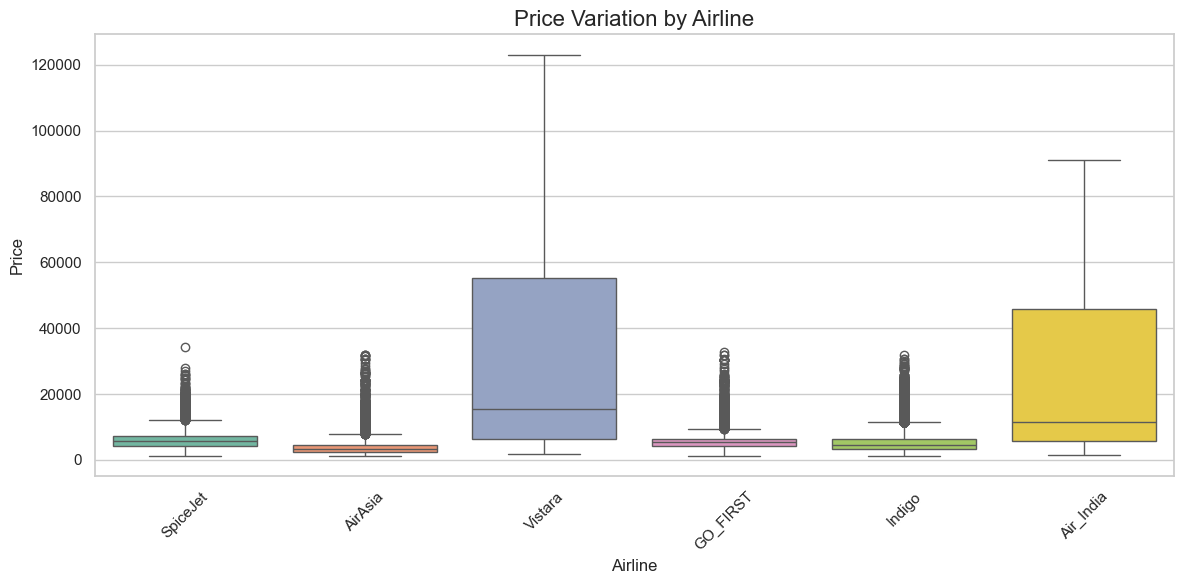

In [5]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="airline", y="price", palette="Set2", hue="airline", legend=False)
plt.title("Price Variation by Airline", fontsize=16)
plt.xlabel("Airline", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("./visualization/price_by_airline.png", dpi=100)
plt.show()

## Plot 3: Price vs. Departure Time

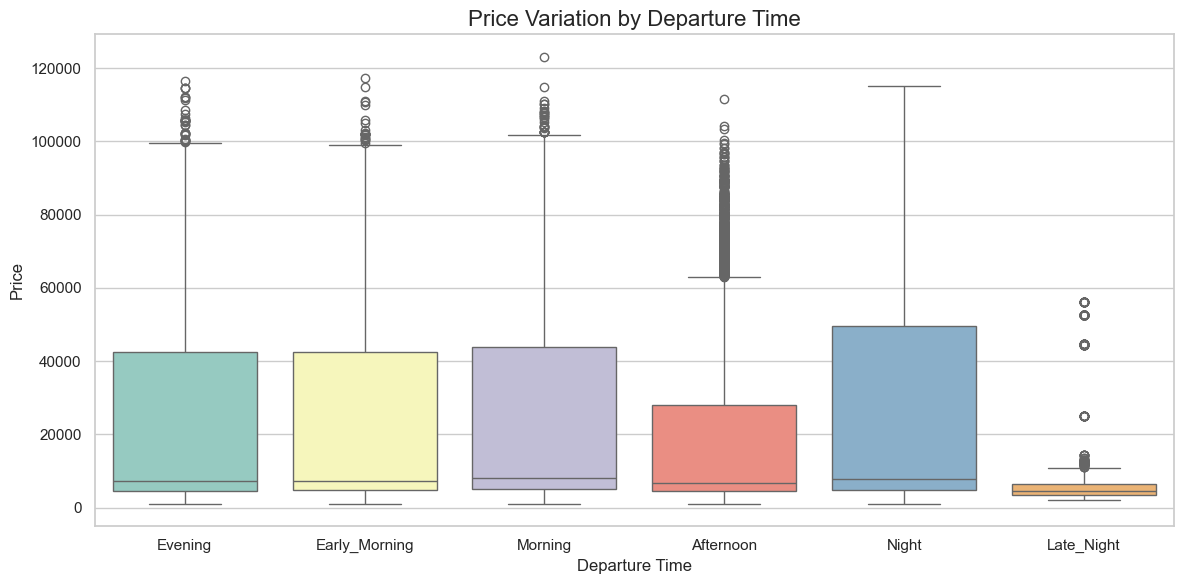

In [6]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="departure_time", y="price", hue="departure_time", palette="Set3")
plt.title("Price Variation by Departure Time", fontsize=16)
plt.xlabel("Departure Time", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.tight_layout()
plt.savefig("./visualization/price_by_departure_time.png", dpi=100)
plt.show()

## Plot 4: Price vs. Flight Class

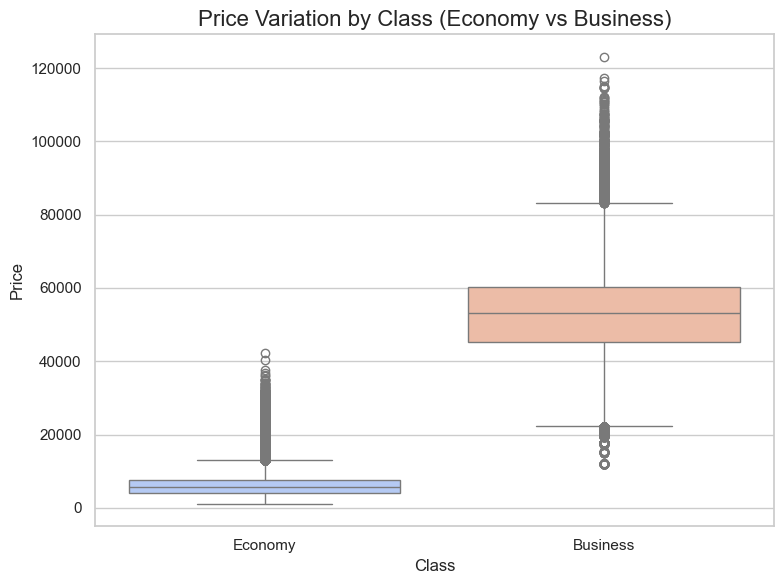

In [7]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="class", y="price", palette="coolwarm", hue="class", legend=False)
plt.title("Price Variation by Class (Economy vs Business)", fontsize=16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.tight_layout()
plt.savefig("./visualization/price_by_class.png", dpi=100)
plt.show()

## Plot 5: Correlation Heatmap for Numerical Variables

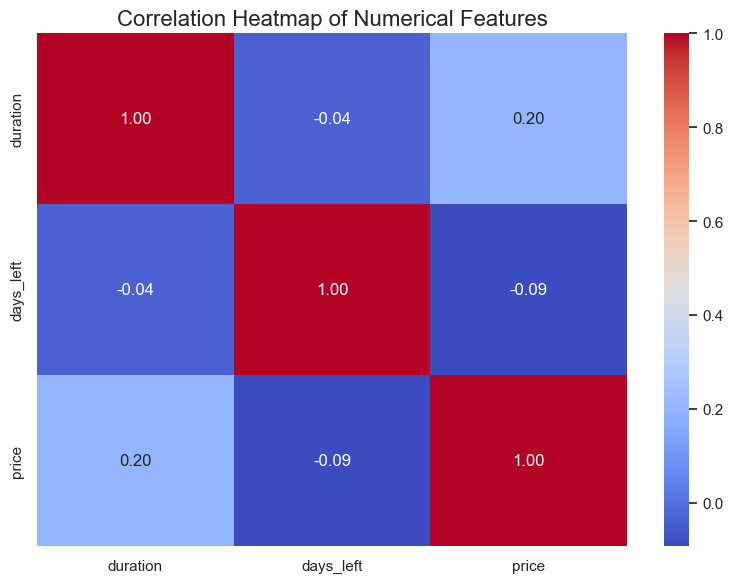

In [8]:
plt.figure(figsize=(8, 6))
correlation = df[["duration", "days_left", "price"]].corr()
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features", fontsize=16)
plt.tight_layout()
plt.savefig("./visualization/correlation_heatmap.png", dpi=100)
plt.show()

# Step 4: Data Cleaning and Preprocessing

In [9]:
# Remove any duplicates
df.drop_duplicates(inplace=True)

# Handle missing values
# Fill missing values for numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns
df[numerical_cols] = df[numerical_cols].apply(lambda col: col.fillna(col.median()))

# Fill missing values for categorical columns
categorical_cols = df.select_dtypes(include=[object]).columns
df[categorical_cols] = df[categorical_cols].apply(lambda col: col.fillna(col.mode()[0]))

# Detect and handle outliers in numerical columns
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

# Convert categorical features to numeric using OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop="first")
categorical_data = encoder.fit_transform(df[categorical_columns])

# Combine encoded data with continuous features
categorical_columns_encoded = encoder.get_feature_names_out(categorical_columns)
encoded_df = pd.DataFrame(categorical_data, columns=categorical_columns_encoded)

continuous_columns = ["duration", "days_left"]
continuous_data = df[continuous_columns]

final_df = pd.concat([encoded_df, continuous_data, df["price"]], axis=1)

# Normalize continuous features using StandardScaler
scaler = StandardScaler()
final_df[continuous_columns] = scaler.fit_transform(final_df[continuous_columns])

# Display processed data
final_df.head()

,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai,...,arrival_time_Night,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai,class_Economy,duration,days_left,price
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.406468,-1.843875,5953.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.384032,-1.843875,5953.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.406468,-1.843875,5956.0
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.395250,-1.843875,5955.0
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.384032,-1.843875,5955.0


In [10]:
# Step 5: Feature Engineering and Dimensionality Reduction
# Apply PCA for dimensionality reduction (optional)
pca = PCA(n_components=10)  # Reducing to 10 principal components
pca_data = pca.fit_transform(final_df.drop(columns=["price"]))

# Combine PCA data with target variable
pca_df = pd.DataFrame(pca_data, columns=[f"PC{i+1}" for i in range(10)])
pca_df["price"] = final_df["price"]

# Display explained variance ratio
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")

Explained Variance Ratio: [0.19409127 0.17222661 0.06381059 0.05119152 0.04600093 0.04349244
 0.04145769 0.03882915 0.03846354 0.03396141]


In [ ]:
from sklearn.ensemble import VotingRegressor

# Step 6: Model Development
# Split data into training and testing sets
X = final_df.drop(columns=["price"])
y = final_df["price"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define models and their hyperparameters for GridSearchCV
param_grids = {
    "Linear Regression": {},
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [10, 20, None],
    },
    "Gradient Boosting": {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7],
    },
}

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
}

# Perform hyperparameter tuning using GridSearchCV
best_estimators = {}
for model_name, model in models.items():
    if param_grids[model_name]:
        grid_search = GridSearchCV(model, param_grids[model_name], scoring="r2", cv=3)
        grid_search.fit(X_train, y_train)
        best_estimators[model_name] = grid_search.best_estimator_
        print(f"Best Parameters for {model_name}: {grid_search.best_params_}")
    else:
        model.fit(X_train, y_train)
        best_estimators[model_name] = model

# Create an ensemble model using VotingRegressor
ensemble_model = VotingRegressor(estimators=[
    (name, estimator) for name, estimator in best_estimators.items()
])

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Evaluate the ensemble model
y_pred = ensemble_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Ensemble Model Performance:\nMSE: {mse}\nMAE: {mae}\nR2: {r2}")

# Visualize ensemble model performance
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Ensemble Model Performance")
plt.show()

In [8]:
# Step 7: Deployment Considerations
# Propose a deployment strategy for the best-performing model
# Save the best model
import joblib

best_model = grid_search.best_estimator_
joblib.dump(best_model, "flight_price_model.pkl")

print("Model saved as 'flight_price_model.pkl' for deployment.")

Model saved as 'flight_price_model.pkl' for deployment.


Model Accuracy: 0.9847722687069231
Model Performance:
MSE: 7849625.54825111
MAE: 1087.116067355234
R2: 0.9847722687069231


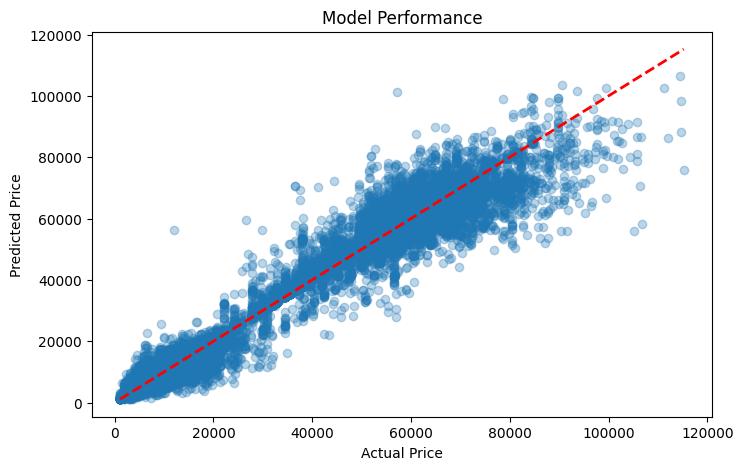

In [16]:
# Step 8: Model Evaluation
# Evaluate the best model
# Load the saved model
best_model = joblib.load("flight_price_model.pkl")

# Evaluate the model on the test set
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Accuracy metrics
accuracy = best_model.score(X_test, y_test)

print(f"Model Accuracy: {accuracy}")
print(f"Model Performance:\nMSE: {mse}\nMAE: {mae}\nR2: {r2}")

# Visualize model performance
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Model Performance")
plt.show()